# ICOS Labelling plots - Atmospheric Data Comparison
Generates atmospheric data plots with comparisons to external data.

## Initial Setup
Instructions for setting up in a virtual environment (venv). To be run from the folder containing the notebooks.

1. `python -m venv .venv`
2. `source .venv/bin/activate`
3. `pip install pandas matplotlib jupyter ipykernel`
4. `python -m ipykernel install --user --name=.venv`
5. `jupyter notebook`

Open this notebook and make sure it is running using the `.venv` kernel.


## Subsequent Usage
The initial setup above only needs performing once. After that, you need only run:

1. `source .venv/bin/activate`
2. `jupyter notebook`

## Files
The notebook expects two folders: `input` and `output`.

The `input` folder should contain a subfolder for a station, and within that the uncompressed data from a QuinCe export containing at least the "ICOS OTC Labelling" format file.

The `output` folder can be empty; the notebook will take care of creating the necessary folder structure inside it.

## Notebook Initialisation
The cell below will initialise the notebook ready for use

In [36]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta
import re
import statistics

## Data Setup
Fill in the variables below to match the details of the data to be processed.

| Variable            | Meaning       |
| ------------------- | ------------- |
| `station_name`      | The name of the station. There should be a folder with the same name in the `input` folder. |
| `dataset`           | The name of the dataset exported from QuinCe. This should be the name of the unzipped export from QuinCe within the folder named after the station name. |


In [37]:
station_name = 'Celtic Explorer'
dataset = '45CE20240503'
xco2_col = 'xCO2 In Atmosphere - Calibrated In Dry Air [mol mol-1]'

xco2_record_type_col = f'{xco2_col} Type'

## General Setup

In [38]:
# Create output folder
output_folder = f'output/{station_name}/{dataset}'
os.makedirs(output_folder, exist_ok=True)

## Load data and set up
Load the data file and perform required pre-preprocessing.

If there is known invalid data in the dataframe, it must be removed here.

In [39]:
datapath=f'input/{station_name}/{dataset}/dataset/ICOS OTC Labelling/{dataset}.csv'
df=pd.read_csv(datapath)
df['Date/Time']=pd.to_datetime(df['Date/Time'])

# Remove invalid data
#df = df[df[water_flow_column] < 100]

# Reset dataset indices
df = df.reindex()

df_ocean = df

/tmp/ipykernel_950791/1806134154.py:2: DtypeWarning: Columns (3,7,15,23,27,31,35,39,47,50,55,58,61,64,67,73,76,79,82,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(datapath)


### Extract sequences of atmospheric measurements

In [62]:
sequence_stdevs = []

last_atm_meas_time = None

current_sequence = []




for row in range(len(df)):
    if df[xco2_record_type_col][row] == 'M':
        m_time = df['Date/Time'][row]

        if last_atm_meas_time is None:
            last_atm_meas_time = m_time
            current_sequence.append(df[xco2_col][row])
        else:
            # If this measurement is < 5 min after the previous one,
            # continue the sequence
            if (m_time - last_atm_meas_time).total_seconds() <= 300:
                last_atm_meas_time = m_time
                current_sequence.append(df[xco2_col][row])
            else:
                # We completed a sequence
                sequence_stdevs.append(statistics.stdev(current_sequence))
                current_sequence = [df[xco2_col][row]]
                last_atm_meas_time = m_time

sequence_stdevs.append(statistics.stdev(current_sequence))

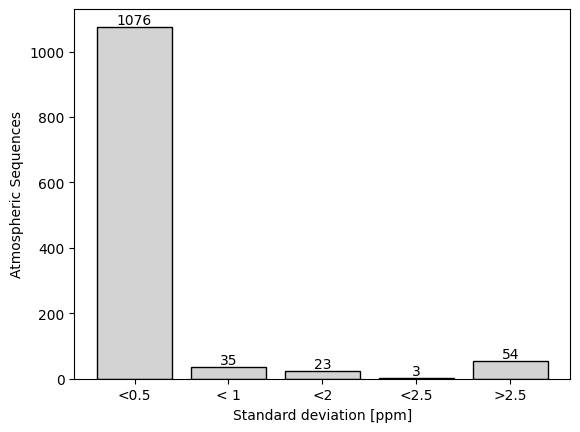

In [63]:
# Define custom bins and categories
bins = [0, 0.5, 1, 2, 2.5, 1000000]
categories = ['<0.5', '< 1', '<2', '<2.5', '>2.5']

hist_data = np.histogram(sequence_stdevs, bins=bins)[0]

# Histogram
plt.bar(categories, hist_data, color='lightgray', edgecolor='black')

# Bar counts
for i, count in enumerate(hist_data):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Standard deviation [ppm]')
plt.ylabel('Atmospheric Sequences')
# Specify the file path and name
output_path = f'{output_folder}/atm_ocean_comparison_std.png'
# Save the plot as a PNG file with high quality
plt.savefig(output_path, dpi=400, bbox_inches='tight')

In [14]:
# Flask data sources:
# Base URL: https://gml.noaa.gov/aftp/data/trace_gases/co2/flask/surface/txt/

# ICE Storhofdi, Iceland: co2_ice_surface-flask_1_ccgg_event.txt (Header = 154)
# IZO Izana, Canary Islands: co2_izo_surface-flask_1_ccgg_event.txt (Header = 160)
# MHD Mace Head, Galway: co2_mhd_surface-flask_1_ccgg_event.txt (Header = 155)

# URL of the text file
url = "https://gml.noaa.gov/aftp/data/trace_gases/co2/flask/surface/txt/co2_izo_surface-flask_1_ccgg_event.txt"

# Send a GET request to the URL and get the content of the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the content of the response into a pandas DataFrame, skipping the first 160 lines
    data = StringIO(response.text)
    df = pd.read_csv(data, skiprows=160, delimiter=r"\s+", comment='#', header=None)

    # Define column names based on the VARIABLE ORDER header
    column_names = ["site_code", "year", "month", "day", "hour", "minute", "second",
                    "datetime", "time_decimal", "air_sample_container_id", "value",
                    "value_unc", "latitude", "longitude", "altitude", "elevation",
                    "intake_height", "method", "event_number", "instrument", "analysis_datetime",
                    "qcflag"]

    # Assign column names to the DataFrame
    df.columns = column_names

    # Now 'df' contains the data from the text file as a pandas DataFrame
   

# Convert the 'datetime' column to datetime objects and set the timezone to UTC
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert('UTC')

# Define the start and end dates in the format 'YYYY-MM-DD'
start_date_str = '2022-10-01'
end_date_str = '2023-03-31'

# Convert start and end dates to datetime objects and set the timezone to UTC
start_date = pd.to_datetime(start_date_str).tz_localize('UTC')
end_date = (pd.to_datetime(end_date_str) + timedelta(days=1)).tz_localize('UTC')  # Adding one day to include end_date

# Select rows between start_date and end_date
df_atm = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

## Compare to NOAA GML Data
Built across multiple cells:

1. Generate data from the ICOS station
2. Generate data from selected NOAA GML stations
3. Draw the plot

In [52]:
plot_data = list()

dt=pd.to_datetime(df_ocean['Date/Time'])
plot_data.append([dt, df_ocean[xco2_col].values, 'black'])


In [69]:
# Flask data sources:
gml_base_url = 'https://gml.noaa.gov/aftp/data/trace_gases/co2/flask/surface/txt/'

gml_column_names = ["site_code", "year", "month", "day", "hour", "minute", "second",
                "datetime", "time_decimal", "air_sample_container_id", "value",
                "value_unc", "latitude", "longitude", "altitude", "elevation",
                "intake_height", "method", "event_number", "instrument", "analysis_datetime",
                "qcflag"]

gml_stations = {
    'ICE': {
        'name': 'Storhofdi, Iceland',
        'filename': 'co2_ice_surface-flask_1_ccgg_event.txt'
    },
    'IZO': {
        'name': 'Izana, Canary Islands',
        'filename': 'co2_izo_surface-flask_1_ccgg_event.txt'
    },
    'MHD': {
        'name': 'Mace Head, Galway',
        'filename': 'co2_mhd_surface-flask_1_ccgg_event.txt'
    }
}

plot_stations = [['ICE', 'red'], ['MHD', 'blue']]

for gml_id, color in plot_stations:
    url = gml_base_url + gml_stations[gml_id]['filename']

    response = requests.get(url)

    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(f'Failed to download GML data for {gml_id}')
    else:
        data = StringIO(response.text)
        
        header_lines_entry = data.readline()
        header_lines = int( re.match('# header_lines : (\\d*)$', header_lines_entry).group(1))

        data.seek(0)
        df = pd.read_csv(data, skiprows=header_lines, delimiter=r"\s+", comment='#', header=None)
        df.columns = gml_column_names

        df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert('UTC')
        df_atm = df[(df['datetime'] >= min(dt)) & (df['datetime'] <= max(dt))]

        plot_data.append([df_atm['datetime'], df_atm['value'].values, color])


<Figure size 600x600 with 0 Axes>

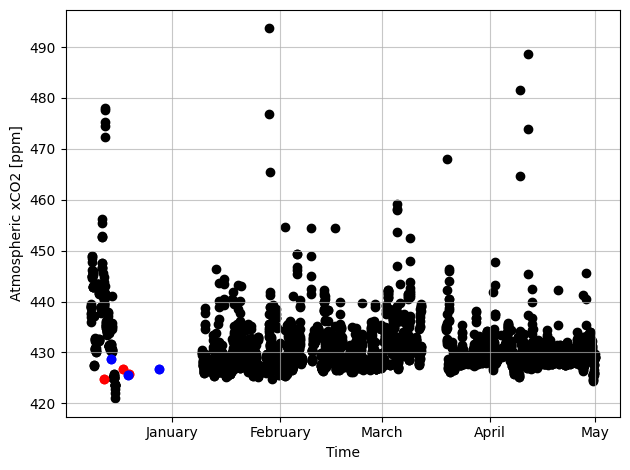

In [71]:
# Create a scatter plot
plt.figure(figsize=(6, 6))  # Optional: set the figure size

# Create a figure and axis
fig, ax = plt.subplots()

for (x, y, color) in plot_data:
    ax.scatter(x, y, color=color)


ax.set_ylabel('Atmospheric xCO2 [ppm]')
ax.set_xlabel('Time')
# Add grid (both major and minor axis)
plt.grid(linestyle='-', alpha=0.7, which='both')

# Set the x-axis ticks to display month names
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))  # %B displays full month name

fig.tight_layout()

# Specify the file path and name
output_path = f'{output_folder}/atm_ocean_comparison.png'

# Save the plot as a PNG file with high quality
plt.savefig(output_path, dpi=400, bbox_inches='tight')

## Variability by Position

Longitude range: -1.524 to 10.9194
Latitude range: 48.7396 to 63.729


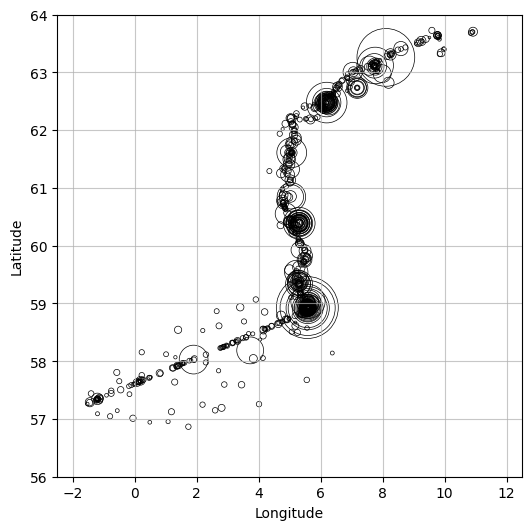

In [32]:
# Assuming df_ocean is your DataFrame
latitudes = df_oc_filtered['Latitude']
longitudes = df_oc_filtered['Longitude']

print(f'Longitude range: {min(longitudes)} to {max(longitudes)}')
print(f'Latitude range: {min(latitudes)} to {max(latitudes)}')

# Create a scatter plot
plt.figure(figsize=(6, 6))  # Optional: set the figure size

# Create a scatter plot with latitude and longitude
plt.scatter(longitudes,latitudes,linewidths=0.5, s=70*co2_values,marker='o', color='blue', edgecolors='black', facecolor='none', label='Data Points')
plt.xlim([-2.5, 12.5])
plt.ylim([56, 64])
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# Add grid (both major and minor axis)
plt.grid( linestyle='-', alpha=0.7, which='both')

# Specify the file path and name
output_path = f'{output_folder}/atm_ocean_std_map.png'

# Save the plot as a PNG file with high quality
plt.savefig(output_path, dpi=400, bbox_inches='tight')